In [1]:
from SimPEG import *
from simpegEM1D import (
    EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, 
    set_mesh_1d, skytem_HM_2015
)
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from simpegEM1D import skytem_HM_2015
wave = skytem_HM_2015()

time = wave.time_gate_center[0::2]
hz = get_vertical_discretization_time(time, facter_tmax=0.5, factor_tmin=10.)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC

wave_type = "stepoff"
if wave_type == "stepoff":
    TDsurvey = EM1DSurveyTD(
        rx_location = np.array([0., 0., 100.+30.]),
        src_location = np.array([0., 0., 100.+30.]),
        topo = np.r_[0., 0., 100.],
        depth = depth,
        rx_type = 'dBzdt',
        wave_type = 'stepoff',
        src_type = 'CircularLoop',
        a = 13.,
        I = 1.,
        time = time,
        base_frequency = 25.,
        use_lowpass_filter=True,
        high_cut_frequency=7e4        
    )
elif wave_type == "skytem":
    time_input_currents = wave.current_times[-7:]
    input_currents = wave.currents[-7:]

    TDsurvey = EM1DSurveyTD(
        rx_location = np.array([0., 0., 100.+30.]),
        src_location = np.array([0., 0., 100.+30.]),
        topo = np.r_[0., 0., 100.],
        depth = depth,
        rx_type = 'dBzdt',
        wave_type = 'general',
        src_type = 'CircularLoop',
        a = 13.,
        I = 1.,
        time = time,
        time_input_currents=time_input_currents,
        input_currents=input_currents,
        n_pulse = 2,
        base_frequency = 25.,
        use_lowpass_filter=True,
        high_cut_frequency=1e4
    )

sig_half = 1e-1
sig_blk = sig_half * 20.
chi_half = 0.
expmap = Maps.ExpMap(mesh1D)

In [3]:
sig  = np.ones(TDsurvey.n_layer)*sig_half
blk_ind = (-30>LocSigZ) & (-70<LocSigZ)
sig[blk_ind] = sig_blk
m_true = np.log(sig)

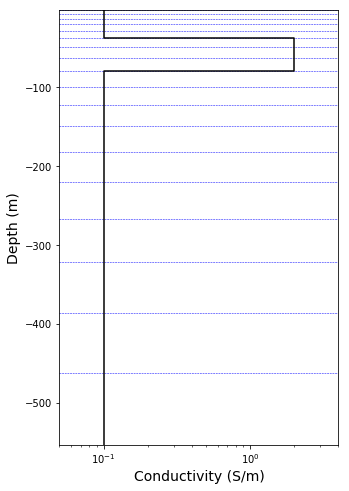

In [4]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, LocSigZ, showlayers=True)

In [5]:
%%time
prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
if prob.ispaired:
    prob.unpair()
if TDsurvey.ispaired:
    TDsurvey.unpair()
prob.pair(TDsurvey)
prob.chi = np.zeros(TDsurvey.n_layer)
d_true = TDsurvey.dpred(m_true)

CPU times: user 38.1 ms, sys: 5.01 ms, total: 43.1 ms
Wall time: 63 ms


In [6]:
TDsurvey.frequency.shape

(69,)

In [7]:
prob.Jvec(m_true, m_true)

array([-3.41329074e-06,  1.10497687e-06,  2.01636930e-06,  1.87004422e-06,
        1.05501782e-06,  3.95813977e-07,  1.08626152e-07,  3.12188824e-08,
        1.17395524e-08,  4.51909634e-09,  1.57112741e-09,  1.79620444e-10,
       -4.16600427e-10, -4.34984394e-10, -2.54165893e-10])

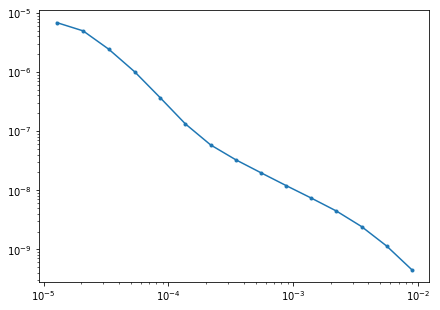

In [8]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -d_true, '.-')
axes.set_xscale('log');
axes.set_yscale('log');

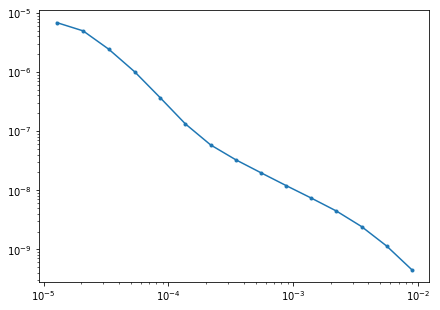

In [9]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -d_true, '.-')
axes.set_xscale('log');
axes.set_yscale('log');

In [10]:
np.random.seed(1)
TDsurvey.dtrue = d_true
std = 0.05
noise = std*abs(TDsurvey.dtrue)*np.random.randn(*TDsurvey.dtrue.shape)
floor = 0.
std = 0.07
TDsurvey.dobs = TDsurvey.dtrue+noise
uncert = abs(TDsurvey.dobs)*std+floor

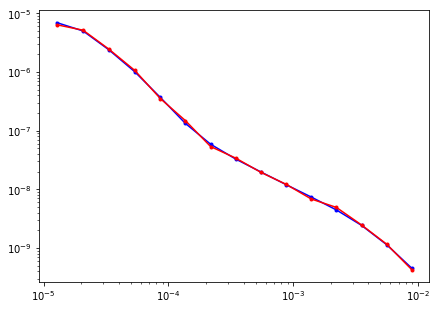

In [10]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -d_true, 'b.-')
axes.plot(TDsurvey.time, -TDsurvey.dobs, 'r.-')
axes.set_xscale('log');
axes.set_yscale('log');

In [11]:
dmisfit = DataMisfit.l2_DataMisfit(TDsurvey)
uncert = (abs(TDsurvey.dobs)*std+floor)
dmisfit.W = 1./ uncert

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [12]:
m0 = np.log(np.ones_like(sig)*sig_half)
d_0 = TDsurvey.dpred(m0)
delta = prob.get_threshold(uncert)

In [13]:
reg = Regularization.Sparse(
    mesh1D,
    mapping=Maps.IdentityMap(mesh1D),
    alpha_s=1.,
    alpha_x=1.
)
p = 0
qx, qz = 2., 2.
reg.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=20, minGNiter=1, fix_Jmatrix=True, coolingRate=2, betaSearch=False,
    chifact_start = 1.
)
opt = Optimization.ProjectedGNCG(maxIter = 25)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2., coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
target = Directives.TargetMisfit()
update_sense = Directives.UpdateSensitivityWeights(threshold=delta)
inv = Inversion.BaseInversion(invProb, directiveList=[IRLS, betaest])
# inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

/Users/sgkang/Projects/simpeg/SimPEG/Directives.py:903: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


In [14]:
%%time
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.68e+01  5.42e+02  0.00e+00  5.42e+02    2.19e+02      0              
   1  2.68e+01  3.66e+02  1.66e+00  4.10e+02    4.17e+01      0              
   2  1.34e+01  2.97e+02  3.29e+00  3.41e+02    6.67e+01      0   Skip BFGS  
   3  1.34e+01  1.28e+02  9.37e+00  2.54e+02    4.88e+01      0              
   4  6.71e+00  6.02e+01  1.22e+01  1.42e+02    5.31e+01      0              
   5  6.71e+00  1.83e+01  1.52e+01  1.21e+02    1.71e+01      0              
   6  3.36e+00  1.49e+01  1.51e+01  6.56e+01    2.06e+01      0   

In [15]:
opt.counter.summary()
xc = opt.recall('xc')

Counters:
  ProjectedGNCG.activeSet                 :       23
  ProjectedGNCG.doEndIteration            :       23
  ProjectedGNCG.doStartIteration          :       23
  ProjectedGNCG.projection                :       95
  ProjectedGNCG.scaleSearchDirection      :       23

Times:                                        mean      sum
  EM1D.Jtvec_approx                       : 4.56e-04, 6.34e-02,  139x
  EM1D.Jvec_approx                        : 4.54e-04, 6.31e-02,  139x
  ProjectedGNCG.findSearchDirection       : 3.05e-02, 7.01e-01,   23x
  ProjectedGNCG.minimize                  : 7.68e+00, 7.68e+00,    1x
  ProjectedGNCG.modifySearchDirection     : 1.06e-01, 2.43e+00,   23x


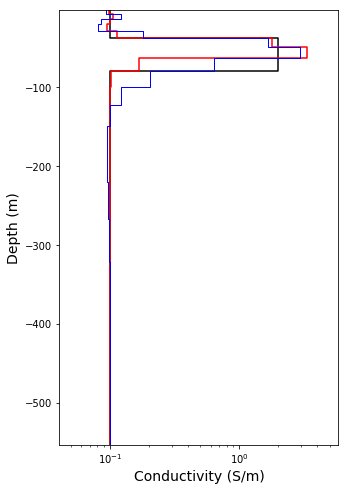

In [16]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, LocSigZ)
Utils1D.plotLayer(expmap*mopt, LocSigZ, showlayers=False, **{'color':'r'})
Utils1D.plotLayer(expmap*invProb.l2model, LocSigZ, showlayers=False, **{'color':'b', 'lw':1.})

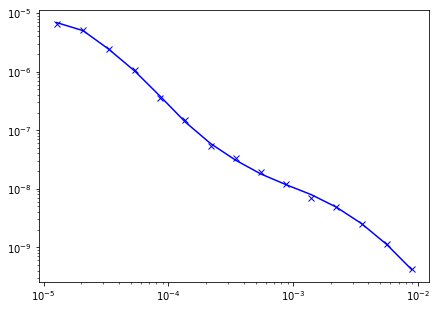

In [17]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -invProb.dpred, 'b-')
axes.plot(TDsurvey.time, -TDsurvey.dobs, 'bx')
axes.set_xscale('log');
axes.set_yscale('log');